# Chapter 12 Portfolio backtesting

In [ ]:
# Environment variables
import os
from dotenv import load_dotenv

# Data manipulation
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import datetime as dt
from datetime import datetime
import itertools
from scipy import special as special
from scipy import stats as stats

# Visualization
import matplotlib.pyplot as plt

# Machine learning - scikit-learn
from sklearn.model_selection import train_test_split

# Machine learning - XGBoost
import xgboost as xgb


# Deep learning - Keras/TensorFlow
import tensorflow as tf
import keras
from keras import initializers, Input, layers
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, AdamW
from plot_keras_history import show_history
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load data
DATA_PATH = "../data/raw/data_ml.csv"
data_ml = pd.read_csv(DATA_PATH)
data_ml['date'] = pd.to_datetime(data_ml['date'])
data_ml['R1M_Usd_C'] = (data_ml['R1M_Usd'] > 0).astype(int) # for classification

In [3]:
# Recreate variables done in notebooks 4 and 5
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

features = X.columns.values.tolist()

## 12.6 First example: a complete backtest

In [4]:
# Create returns pivot
returns = data_ml.pivot(index='date', columns='stock_id', values='R1M_Usd')
returns = returns.dropna(axis=1, how='all').dropna(axis=0, how='all')
returns = returns.fillna(returns.mean())

# Backtesting parameters
sep_oos= "2007-01-01"                                          # Starting point for backtest
ticks= list(data_ml['stock_id'].unique())                      # List of all asset ids
N= len(ticks)                                                  # Max number of assets
t_oos= list(returns.index[returns.index>sep_oos].values)       # Out-of-sample dates
t_as= list(returns.index.values)                               # All dates
Tt= len(t_oos)                                                 # Nb of dates
nb_port = 2                                                    # Nb of portfolios/strategies
portf_weights= np.zeros(shape=(Tt, nb_port, max(ticks)+1))     # Initialize portfolio weights
portf_returns= np.zeros(shape=(Tt, nb_port))                   # Initialize portfolio returns 

In [63]:
def weights_xgb(train_data, test_data, features):
    train_features= train_data[features]                                                                    # Indep. variable
    train_label= train_data['R12M_Usd']/ np.exp(train_data['Vol1Y_Usd'])                                    # Dep. variable ##T##
    ind = (train_label < np.quantile(train_label, 0.2))|(train_label > np.quantile(train_label, 0.8))       # Filter
    train_features= train_features.loc[ind]                                                                 # Filtered features
    train_label= train_label.loc[ind]                                                                       # Filtered label
    train_matrix=xgb.DMatrix(train_features, label=train_label)                                             # XGB format!
    params={'eta' : 0.3,                                                                                    # Learning rate
      'objective' : "reg:squarederror",                                                                     # Objective function
      'max_depth' : 4}                                                                                      # Maximum depth of trees
    fit_xgb =xgb.train(params, train_matrix,num_boost_round=80)                                             # Number of trees used
    test_features=test_data[features]                                                                       # Test sample => XGB format
    test_matrix=xgb.DMatrix(test_features)                                                                  # XGB format!
    pred = fit_xgb.predict(test_matrix)                                                                     # Single prediction  
    w_names=test_data["stock_id"]                                                                           # Stocks' list
    w = pred > np.median(pred)                                                                              # Keep only the 50% best predictions                   
    w = w / np.sum(w)                                                                                       # Best predictions, equally-weighted
    return w, w_names

In [64]:
def portf_compo(train_data, test_data, features, j):
    if j == 0:                                                                       # This is the benchmark
        N = len(test_data["stock_id"])                                               # Test data dictates allocation
        w = np.repeat(1/N,N)                                                         # EW portfolio
        w_names=test_data["stock_id"]                                                # Asset names
        return w, w_names               
    elif j == 1:                                                                     # This is the ML strategy.                    
        return weights_xgb(train_data, test_data, features)

In [65]:
m_offset = 12                                                                       # Offset in months for buffer period(label)
train_size = 5                                                                      # Size of training set in years
for t in range(len(t_oos)-1):                                                       # Stop before last date: no fwd ret.!
    print(t_oos[t])                                                                 # Just checking the date status
    current_date = pd.to_datetime(t_oos[t])
    ind = (
        (data_ml['date'] < (current_date - dt.timedelta(days=m_offset*30))) &
        (data_ml['date'] > (current_date - dt.timedelta(days=m_offset*30) - dt.timedelta(days=365 * train_size)) )
    )
    train_data = data_ml.loc[ind, :]                                                # Train sample
    test_data = data_ml.loc[data_ml['date'] == current_date, :]                     # Test sample  
    realized_returns= test_data["R1M_Usd"]                                          # Computing returns via: 1M holding period!
    for j in range(nb_port):
        temp_weights, stocks = portf_compo(train_data, test_data, features, j)      # Weights
        portf_weights[t,j,stocks] = temp_weights                                    # Allocate weights 
        portf_returns[t,j] = np.sum(temp_weights * realized_returns)                # Compute returns

2007-01-31T00:00:00.000000000
2007-02-28T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-04-30T00:00:00.000000000
2007-05-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-07-31T00:00:00.000000000
2007-08-31T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-10-31T00:00:00.000000000
2007-11-30T00:00:00.000000000
2007-12-31T00:00:00.000000000
2008-01-31T00:00:00.000000000
2008-02-29T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-04-30T00:00:00.000000000
2008-05-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-07-31T00:00:00.000000000
2008-08-31T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-10-31T00:00:00.000000000
2008-11-30T00:00:00.000000000
2008-12-31T00:00:00.000000000
2009-01-31T00:00:00.000000000
2009-02-28T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-04-30T00:00:00.000000000
2009-05-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-07-31T00:00:00.000000000
2009-08-31T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-10-31

In [66]:
def turnover(weights, asset_returns, t_oos):
    turn = 0
    for t in range(1, len(t_oos)):
        realised_returns = asset_returns[returns.index == t_oos[t]].values
        prior_weights = weights[t-1] * (1+realised_returns)                         # Before rebalancing
        turn =turn + np.sum(np.abs(weights[t] - prior_weights/np.sum(prior_weights)))
    return turn/(len(t_oos)-1)

In [67]:
def perf_met(portf_returns, weights, asset_returns, t_oos):
    avg_ret = np.nanmean(portf_returns)                                             # Arithmetic mean 
    vol = np.nanstd(portf_returns, ddof=1)                                          # Volatility
    Sharpe_ratio = avg_ret / vol                                                    # Sharpe ratio
    VaR_5 = np.quantile(portf_returns, 0.05)                                        # Value-at-risk
    turn = turnover(weights, asset_returns, t_oos)                                  # using the turnover function
    met = [avg_ret, vol, Sharpe_ratio, VaR_5, turn]                                 # Aggregation of all of this
    return met

In [68]:
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):   
    J = weights.shape[1]                                                            # Number of strategies                                                    
    met = []                                                                        # Initialization of metrics
    for j in range(J):                                                              # One slighlty less ugly loop
        temp_met = perf_met(portf_returns[:,j], weights[:,j,:], asset_returns, t_oos)
        met.append(temp_met)
    return pd.DataFrame(met, index=strat_name, columns = ['avg_ret', 'vol', 'Sharpe_ratio', 'VaR_5', 'turn']) # Stores the name of the strat

In [69]:
asset_returns = data_ml[['date', 'stock_id', 'R1M_Usd']].pivot(index='date', columns='stock_id',values='R1M_Usd') 
na = list(set(np.arange(max(asset_returns.columns)+1)).difference(set(asset_returns.columns)))          # find the missing stock_id
asset_returns[na]=0                                                                                     # Adding into asset return dataframe
asset_returns = asset_returns.loc[:,sorted(asset_returns.columns)]
asset_returns.fillna(0, inplace=True)                                                                   # Zero returns for missing points
perf_met_multi(portf_returns, portf_weights, asset_returns, t_oos,strat_name = ["EW", "XGB_SR"])

,avg_ret,vol,Sharpe_ratio,VaR_5,turn
EW,0.010654,0.056676,0.187987,-0.076794,0.078321
XGB_SR,0.013573,0.063157,0.214916,-0.086843,0.567481


d:\Code\ml-for-factor-investing\.venv\Lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


<Axes: xlabel='date', ylabel='Yearly performance'>

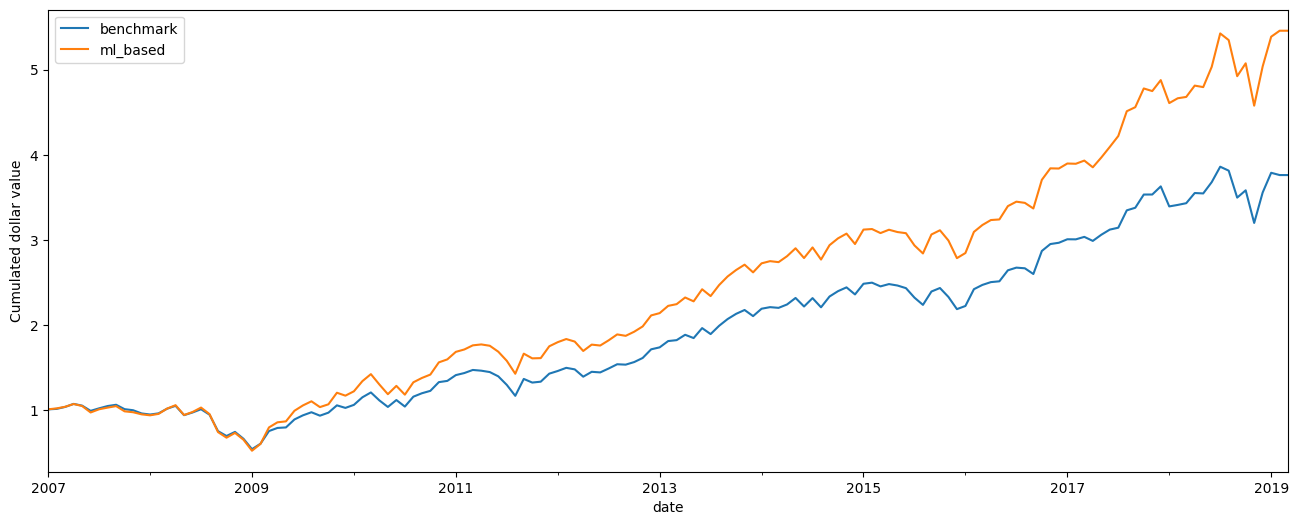

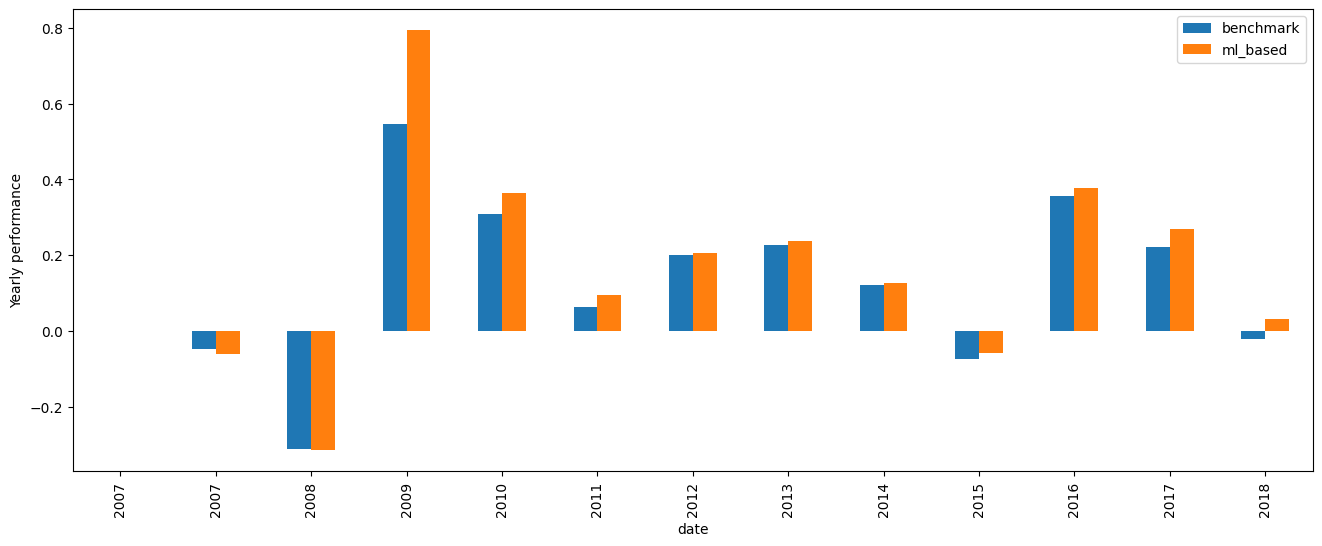

In [74]:
g1 = pd.DataFrame([t_oos, np.cumprod(1+portf_returns[:,0]), np.cumprod(1+portf_returns[:,1])],index = ["date","benchmark","ml_based"]).T # Creating cumulated timeseries
g1.reset_index(inplace=True)                                                                                                             # Data wrangling
g1['date_month']=pd.to_datetime(g1['date']).dt.month                    # Creating a new column to select dataframe partition for secong plot (yearly performance)
g1.set_index('date',inplace=True)                                       # Setting date index for plots
g2=g1[g1['date_month']==12]                                             # Selecting pseudo end of year NAV
g2=pd.concat([g2, g1.iloc[[0]]])                                              # Adding the first date of Jan 2007
g2.sort_index(inplace=True)                                             # Sorting dates 
g1[["benchmark","ml_based"]].plot(figsize=[16,6],ylabel='Cumulated dollar value')                                                        # plot evidently!
g2_plot = g2[["benchmark","ml_based"]].pct_change(1).infer_objects(copy=False)
g2_plot.index = pd.to_datetime(g2_plot.index).year
g2_plot.plot.bar(figsize=[16,6], ylabel='Yearly performance')                                          # plot evidently!

## 12.7 Second example: backtest overfitting

In [75]:
def strat(data, feature, thresh, direction):
    data_tmp = data[[feature, 'date', 'R1M_Usd']].copy()                        # Data for individual feature
    data_tmp['decision'] = direction*data_tmp[feature] > direction*thresh       # Investment decision as a Boolean
    data_tmp =  data_tmp.groupby('date').apply(
        lambda x: np.sum(x['decision']/np.sum(x['decision']) * x['R1M_Usd']), include_groups=False)   # Date-by-date  analysis
    avg = np.nanmean(data_tmp)                                                  # Portfolio average return
    sd = np.nanstd(data_tmp, ddof=1)                                            # Portfolio volatility non annualised
    SR = avg / sd                                                               # Portfolio sharpe ratio
    return np.around([avg, sd, SR],4)

In [76]:
strat(data_ml, "Pb", 0.3, 1)                                                                # Large cap

array([0.0106, 0.0489, 0.2157])

In [77]:
feature = ["Div_Yld", "Ebit_Bv", "Mkt_Cap_6M_Usd", "Mom_11M_Usd", "Pb", "Vol1Y_Usd"]
thresh = np.arange(0.2, 0.9, 0.1)                                                           # Threshold
direction = np.array([1,-1])                                                                # Decision direction

<Axes: xlabel='thresh', ylabel='Direction = 1'>

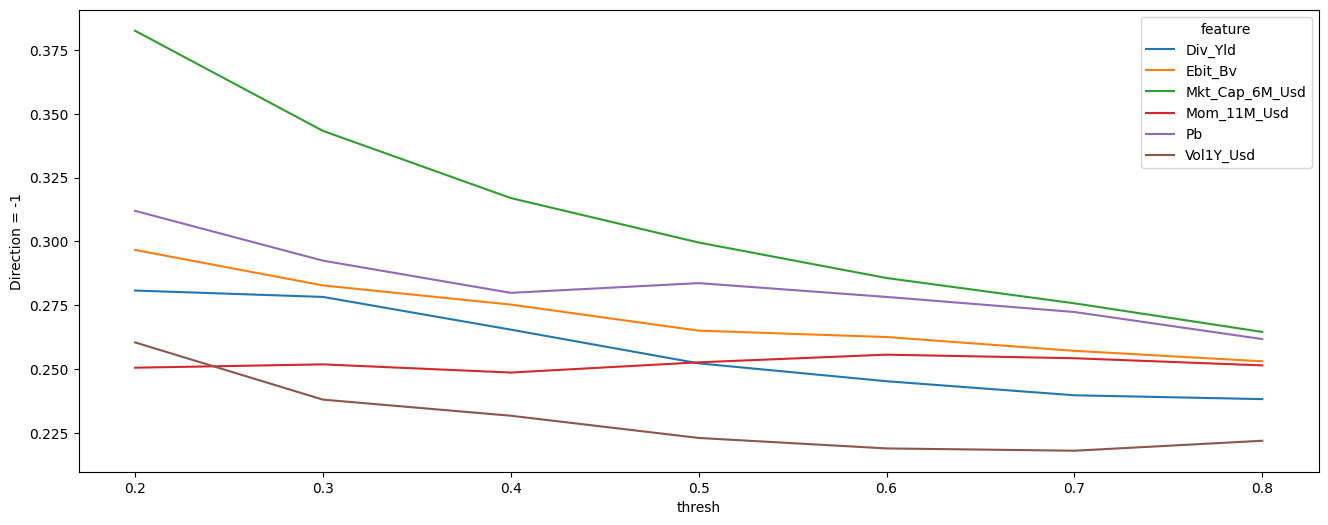

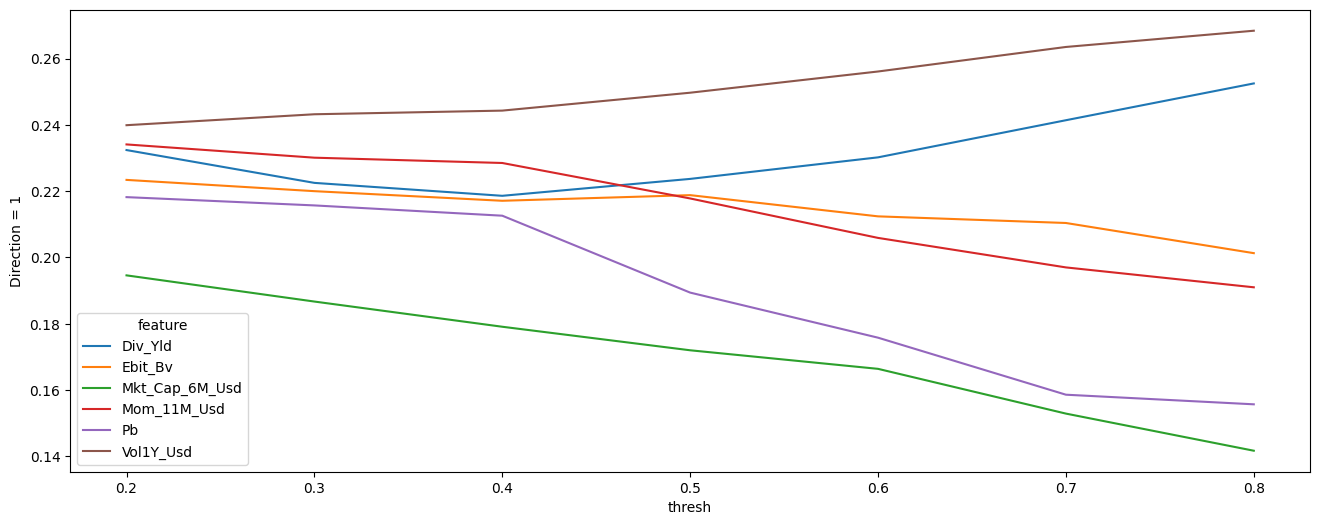

In [78]:
grd = []                                                                 # Empty placeholder, parameters for the grid search 
for f, t, d in itertools.product(feature,thresh,direction):              # Parameters for the grid search 
    strat_data=[]                                                        # Empty placeholder, dataframe for the function
    strat_data=pd.DataFrame(strat(data_ml,f,t,d)).T                      # Function on which to apply the grid search
    strat_data.rename(columns={0: 'avg', 1: 'sd',2:'SR'}, inplace=True)  # Change columns names
    strat_data[['feature', 'thresh', 'direction']]=f, t, d               # Feeding parameters to construc the dataframe
    grd.append(strat_data)                                               # Appending/inserting 
grd = pd.concat(grd)[['feature','thresh','direction','avg', 'sd', 'SR']] # Putting all together and reordering columns

grd[grd['direction']==-1].pivot(index='thresh',columns='feature',values='SR').plot(figsize=[16,6],ylabel='Direction = -1') # Plot!
grd[grd['direction']==1].pivot(index='thresh',columns='feature',values='SR').plot(figsize=[16,6],ylabel='Direction = 1')   # Plot!

In [79]:
def DSR(SR, Tt, M, g3, g4, SR_m, SR_v):                                                                         # First, we build the function
    gamma = -special.digamma(1)                                                                                 # Euler-Mascheroni constant
    SR_star = SR_m + np.sqrt(SR_v)*((1-gamma)*stats.norm.ppf(1-1/M) + gamma*stats.norm.ppf(1-1/M/np.exp(1)))    # SR*
    num = (SR-SR_star) * np.sqrt(Tt-1)                                                                          # Numerator
    den = np.sqrt(1 - g3*SR + (g4-1)/4*SR**2)                                                                   # Denominator
    return round(stats.norm.cdf(num/den),4)

In [80]:
M = grd.shape[0]                                                                                                # Number of strategies we tested
SR = np.max(grd['SR'])                                                                                          # The SR we want to test
SR_m = np.mean(grd['SR'])                                                                                       # Average SR across all strategies
SR_v = np.var(grd['SR'], ddof=1)                                                                                # Std dev of SR
data_tmp = data_ml[['Mkt_Cap_6M_Usd', 'date', 'R1M_Usd']].copy()                                                # feature = Mkt_Cap 
data_tmp.rename({'Mkt_Cap_6M_Usd':'feature'}, axis=1, inplace=True)
data_tmp['decision'] = data_tmp['feature'] < 0.2                                                                # Investment decision: 0.2 is the best threshold
returns_DSR = data_tmp.groupby('date').apply(                                                                   # Date-by-date  analysis
    lambda x:np.sum(x['decision']/np.sum(x['decision']) * x['R1M_Usd']), include_groups=False)                                        # Asset contribution, weight * return
g3 = stats.skew(returns_DSR)                                                                                    # Function/method from Scipy.stats
g4 = stats.kurtosis(returns_DSR, fisher=False)                                                                  # Function/method from Scipy.stats
Tt = returns_DSR.shape[0]                                                                                       # Number of dates
DSR(SR, Tt, M, g3, g4, SR_m, SR_v)                                                                              # The sought value!

np.float64(0.7263)

## 12.8 Coding exercises

In [5]:
# --- Step 1: EW Portfolio Returns with pandas (tidyverse style, no loop) ---
# 'returns' DataFrame: index=date, columns=stock_id, values=returns
# EW portfolio return = mean across stocks for each date

ew_portfolio_returns = returns.mean(axis=1)
ew_portfolio_returns

date
1998-11-30    0.039823
1998-12-31   -0.000219
1999-01-31   -0.037653
1999-02-28    0.003872
1999-03-31    0.066653
                ...   
2018-11-30   -0.097362
2018-12-31    0.087065
2019-01-31    0.051612
2019-02-28    0.003070
2019-03-31    0.023989
Length: 245, dtype: float64

In [6]:
# --- Step 2: Advanced Weighting Function (Equation 12.3) ---
def advanced_weights(
    mu, Sigma, Lambda, w_prev, 
    lam=1.0, kappa_R=0.0, kappa_D=0.0, eta=0.0
):
    """
    Compute advanced portfolio weights as in Eq. 12.3.
    mu: expected returns (N,)
    Sigma: covariance matrix (N,N)
    Lambda: diagonal matrix (N,N) or vector (N,)
    w_prev: previous weights (N,)
    lam: risk aversion parameter (lambda)
    kappa_R: risk penalty parameter
    kappa_D: deviation penalty parameter
    eta: Lagrange multiplier (set to 0 for unconstrained)
    Returns: optimal weights (N,)
    """
    N = len(mu)
    if Lambda.ndim == 1:
        Lambda = np.diag(Lambda)
    I_N = np.eye(N)
    one_N = np.ones(N)
    # Matrix to invert
    A = lam * Sigma + 2 * kappa_R * Lambda + 2 * kappa_D * I_N
    # Right-hand side
    b = mu + eta * one_N + 2 * kappa_R * Lambda @ w_prev
    # Solve for weights
    w_star = np.linalg.solve(A, b)
    return w_star

<Axes: title={'center': 'Advanced Weighting Sensitivity (No Loop)'}, xlabel='date'>

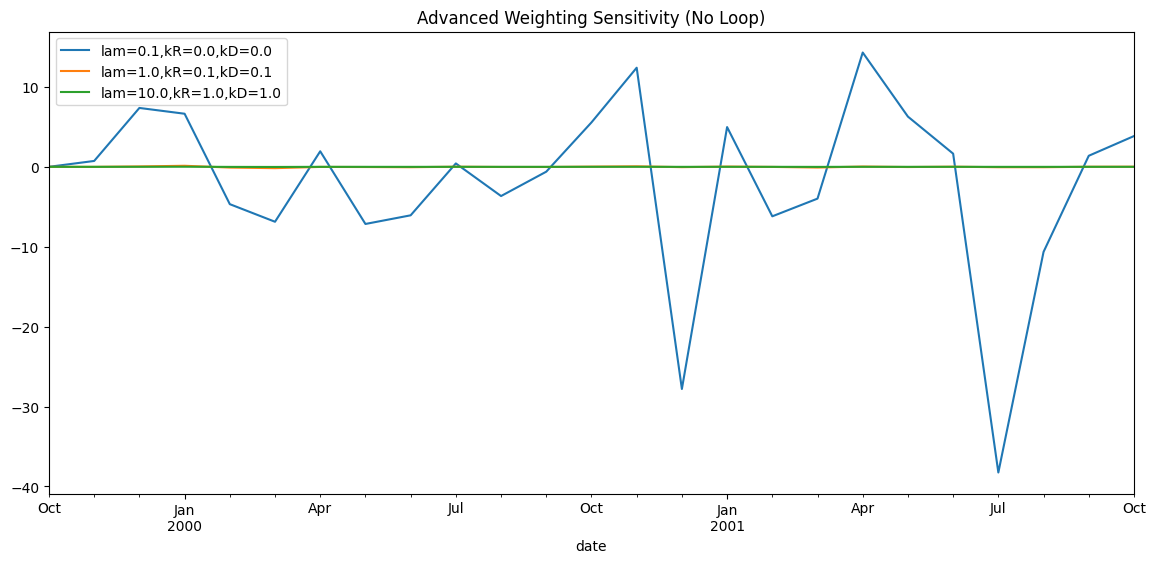

In [7]:
# --- Step 3: Small Backtest & Sensitivity Analysis (Functional Style, No Loop) ---
# Example: Use a rolling window to compute weights and returns

window = 12  # months
param_grid = pd.DataFrame({
    'lam': [0.1, 1, 10],
    'kappa_R': [0, 0.1, 1],
    'kappa_D': [0, 0.1, 1]
})

# Use a small subset for demonstration
dates = returns.index[:36]  # 3 years
assets = returns.columns[:5]  # 5 assets
returns_sub = returns.loc[dates, assets]

# Prepare rolling expected returns and covariances
def get_mu_sigma(df):
    mu = df.mean().values
    Sigma = df.cov().values
    return mu, Sigma

# Previous weights start at zero
w0 = np.zeros(len(assets))
Lambda = np.ones(len(assets))

# For each parameter set, compute portfolio returns (no explicit loop, use apply)
def run_backtest(params):
    lam, kappa_R, kappa_D = params['lam'], params['kappa_R'], params['kappa_D']
    idx = np.arange(window, len(returns_sub)+1)
    def get_weights(i):
        df = returns_sub.iloc[i-window:i]
        mu, Sigma = get_mu_sigma(df)
        return advanced_weights(mu, Sigma, Lambda, w0, lam, kappa_R, kappa_D)
    weights = np.array(list(map(get_weights, idx)))
    weights_df = pd.DataFrame(weights, index=returns_sub.index[window-1:], columns=assets)
    portf_ret = (weights_df.shift(1) * returns_sub.loc[weights_df.index]).sum(axis=1)
    return portf_ret

# Sensitivity analysis: apply to all parameter sets
results = param_grid.apply(run_backtest, axis=1)
results.index = [f"lam={row.lam},kR={row.kappa_R},kD={row.kappa_D}" for _, row in param_grid.iterrows()]
results = results.T
results.plot(figsize=(14,6), title='Advanced Weighting Sensitivity (No Loop)')

In [18]:
def create_branch(input_shape):
    inp = Input(shape=input_shape)
    # Increased width (64) + Batch Norm + Dropout
    x = Dense(64)(inp)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    # Note: NO sigmoid output here. We return the feature layer.
    return inp, x

# Create 3 branches
inp1, feat_layer1 = create_branch((X1_train.shape[1],))
inp2, feat_layer2 = create_branch((X2_train.shape[1],))
inp3, feat_layer3 = create_branch((X3_train.shape[1],))

# Meta-network (Late Fusion)
# We concatenate the learned features (32+32+32 = 96 inputs to meta)
concat = Concatenate()([feat_layer1, feat_layer2, feat_layer3])

m = Dense(64, activation='relu')(concat)
m = Dropout(0.3)(m)
m = Dense(32, activation='relu')(m)
meta_out = Dense(1, activation='sigmoid')(m) # Final prediction

# Build Model
ensemble_model = Model(inputs=[inp1, inp2, inp3], outputs=meta_out)

# Callbacks (The "Auto-Pilot")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Compile
ensemble_model.compile(optimizer=AdamW(learning_rate=0.001), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

# Train (Increased epochs, relying on EarlyStopping to stop)
history = ensemble_model.fit(
    [X1_train, X2_train, X3_train], 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.5494 - loss: 0.6890 - val_accuracy: 0.5512 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 2/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.5523 - loss: 0.6875 - val_accuracy: 0.5520 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 3/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.5528 - loss: 0.6870 - val_accuracy: 0.5520 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 4/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.5526 - loss: 0.6867 - val_accuracy: 0.5520 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 5/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.5534 - loss: 0.6868 - val_accuracy: 0.5524 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 6/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.5527 - loss: 0.6866 - val_accuracy: 0.5520 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 7/100
5668/5668 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accura

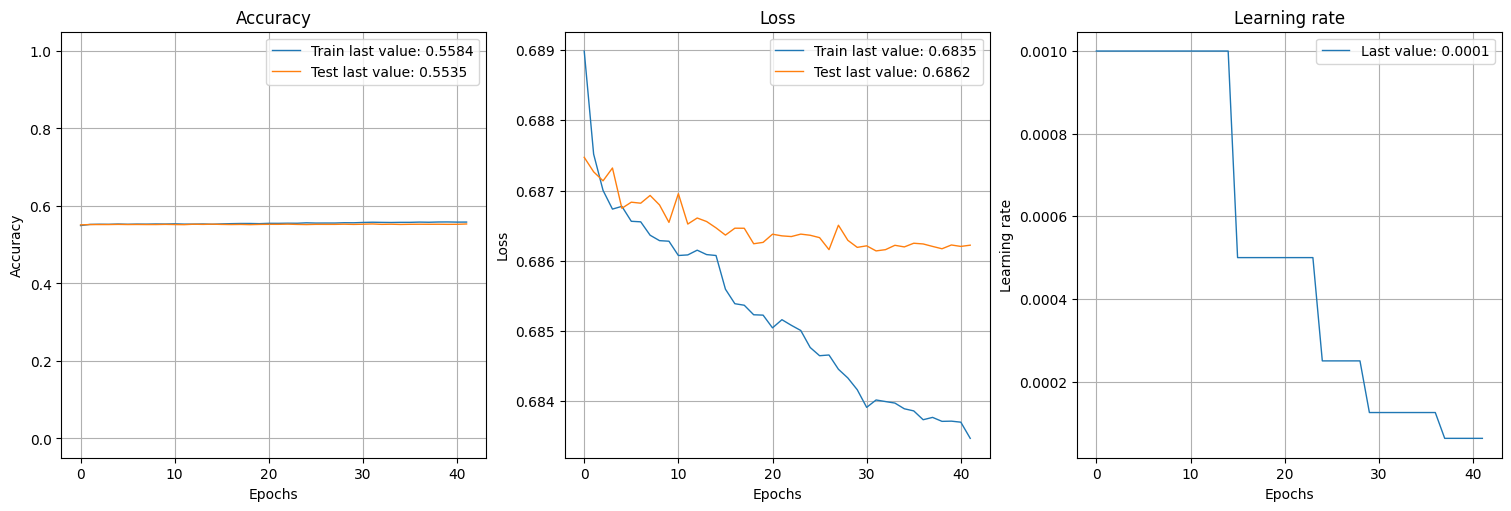

In [19]:
# Visualize training history
history = ensemble_model.history
show_history(history)